# Finescale Mixing Parametrizations: Development

From Whalen et al (2012) Supplementary

QC:

1. All Argo float profiles with an ‘A’ quality rating (all real-time quality control tests passed) between June 2006 and December 2011 were selected.
1. The mixed layer was removed before implementing the parameterization since the mixed layer appears at a region of the high strain variance, and the parameterization treats all strain variance as internal waves, leading to an inaccurate estimate of the mixing. The same problem exists for other areas of low stratification near the surface (for example, mode water).
1. The variable temperature criterion (de Boyer Montegut et al., 2004) was therefore applied twice, once to remove the mixed layer, and a second time treating the bottom of the mixed layer as the surface.
1. Profiles with large spikes from any of the sensors were taken out of the dataset, and small salinity spikes needed to be removed from a subset of the profiles.

Steps:

1. Each profile containing 15 m resolution or better was divided into 200 m half-overlapping segments.
1. Segments were discarded if N² \< 10−9 s−2 or if N² varied by more than 6 x 10−4 s−2, to remove sharp strain gradients not associated with internal waves.
1. We consider the vertical resolution of the segments since this could have an effect on the calculated dissipation rates. The majority of the segments had either 2 m or 10 m resolution, with similar mean ! (the mean 10 m resolution estimate above 500 m was only 10% larger), while the standard deviation of dissipation rate for 2 m data was 40% larger.

______________________________________________________________________

Whalen et al (2015):

To calculate the strain variance ⟨ξ²⟩, each segment
was detrended, windowed using a sin² 10% taper, and
spatially Fourier transformed to generate the spectrum
Sstr for each segment. The spectrum is corrected for first
differencing by dividing by the transfer function sinc²
(kzDz/2p), where Dz is the vertical resolution of the
segment. Argo data are either point measurements or
averages over a depth interval, which is currently not
identified in the metadata. Here, we correct for this
whenever we know the sampling scheme of the profile
by dividing by the same transfer function a second time
\[a correction not included in Whalen et al. (2012)\]. This
slightly raises the variances in the bin-averaged cases.
The average increase in the dissipation rate for the Atlantic Ocean is a factor of 1.02, with a range of 1 to 2.6.

Strain
\\begin{equation}
ξ_z = \\frac{N² - N²\_{fit}}{\\bar{N²}}
\\end{equation}

______________________________________________________________________

Waterman et al (2014)

Segments were constructed
both starting from the surface and the bottom, with
near-surface values computed from the vertical segments defined starting from the surface, near-bottom
values computed from the vertical segments defined
starting from the bottom, and interior values computed
from an average of top–down- and bottom–up-defined
segments.

In [1]:
%load_ext watermark

import argopy
import cf_xarray as cfxr
import dask
import dcpy
import gsw
import matplotlib as mpl
import matplotlib.pyplot as plt
import mixsea
import numpy as np
import pandas as pd
import scipy
import scipy.integrate
import seawater as sw
from dcpy.finestructure import estimate_turb_segment
from scipy import signal
from scipy.io import loadmat

import xarray as xr

plt.style.use("bmh")
mpl.rcParams["figure.dpi"] = 140
mpl.rcParams["lines.linewidth"] = 1
dirname = "/home/deepak/datasets/finestructure/"

%watermark -iv

dask      : 2021.6.2
cf_xarray : 0.4.1.dev21+gab9dc66
scipy     : 1.5.3
eddydiff  : 0.1
pandas    : 1.2.3
seawater  : 3.3.4
dcpy      : 0.1
mixsea    : 0.1.0
xarray    : 0.17.1.dev3+g48378c4b1
numpy     : 1.20.2
argopy    : 0.1.7
gsw       : 3.4.0
matplotlib: 3.4.1



In [3]:
kunze = dcpy.oceans.read_kunze_2017_finestructure()

## Check against Kunze & mixsea

In [4]:
cruise = "317519930704"
cast = 19
kunze_cruise = kunze.groupby("cruise").get_group(cruise).query(f"drop == {cast}")

ctd = xr.open_mfdataset(f"{dirname}/../cchdo/{cruise}/*ctd.nc").load()
del ctd.attrs["comments"]

profile = ctd.query({"N_PROF": f"cast == {cast}"}).squeeze()
profile.ctd_salinity.attrs["standard_name"] = "sea_water_salinity"
profile["γ"] = dcpy.oceans.neutral_density(profile).reset_coords(drop=True)

# Polzin et al (2015) recommend sorting then calculating N2
initial_pressure = profile.pressure.reset_coords(drop=True)
profile = profile.sortby("γ")
profile["pressure"] = initial_pressure
profile = profile.swap_dims({"N_LEVELS": "pressure"})
profile = profile.isel(pressure=profile.pressure.notnull())

profile["N2"] = (
    "pressure",
    np.append(
        dcpy.eos.bfrq(
            profile.ctd_salinity,
            profile.ctd_temperature,
            profile.pressure,
            dim="pressure",
        )[0]
        # .interp(pressure_mid=profile.pressure.data)
        .data[1:],
        [np.nan, np.nan],
    ),
)

SA = gsw.SA_from_SP(
    profile.ctd_salinity, profile.pressure, profile.longitude, profile.latitude
)
CT = gsw.CT_from_t(SA, profile.ctd_temperature, profile.pressure)
N2gsw, p = gsw.Nsquared(SA, CT, profile.pressure, profile.latitude)
N2gsw = xr.DataArray(N2gsw, dims="pressure", coords={"pressure": p})

# profile["N2gsw"] = ("pressure", N2gsw.interp(pressure=profile.pressure.data).data)
profile["N2gsw"] = ("pressure", np.append(N2gsw, np.nan))

# Density variables σp, σθ, σ3, and γ_n and stratification N2 were then computed
profile["σθ"] = dcpy.eos.pden(
    profile.ctd_salinity, profile.ctd_temperature, profile.pressure, 0
)
profile["σ3"] = dcpy.eos.pden(
    profile.ctd_salinity, profile.ctd_temperature, profile.pressure, 3000
)

profile["N2θ"] = (
    -9.81
    / 1030
    * profile.σθ.cf.differentiate("sea_water_pressure", positive_upward=True)
)
profile["N23"] = (
    -9.81
    / 1030
    * profile.σ3.cf.differentiate("sea_water_pressure", positive_upward=True)
)
profile["N2γ"] = (
    -9.81
    / 1030
    * profile.γ.cf.differentiate("sea_water_pressure", positive_upward=True)
)

profile["pres"] = profile["pressure"]

Break up in to half overlapping segments

In [5]:
segmented = (
    profile.drop_vars("sample")
    .sel(pressure=slice(148, None))
    .rolling(pressure=128, min_periods=1)
    .construct(window_dim="segment", stride=64)
    .isel(pressure=slice(2, None))
)
segmented.coords["pres_mean"] = segmented.pres.mean("segment")
segmented["segment"] = np.arange(0, 2 * segmented.sizes["segment"], 2)
segmented

<xarray.Dataset>
Dimensions:             (pressure: 28, segment: 128)
Coordinates:
    latitude            float64 2.002
    longitude           float64 -25.2
    time                datetime64[ns] 1993-07-11T06:14:00
    expocode            object '3175MB93'
    station             object '16'
    cast                int8 19
    reference_pressure  int64 0
  * pressure            (pressure) float64 404.0 532.0 ... 3.732e+03 3.86e+03
    pres_mean           (pressure) float64 277.0 405.0 ... 3.605e+03 3.733e+03
  * segment             (segment) int64 0 2 4 6 8 10 ... 244 246 248 250 252 254
Data variables: (12/16)
    section_id          object 'AR21b'
    ctd_temperature     (pressure, segment) float32 14.0 13.87 ... 2.389 2.392
    ctd_temperature_qc  (pressure, segment) float32 2.0 2.0 2.0 ... 2.0 2.0 2.0
    ctd_salinity        (pressure, segment) float32 35.38 35.38 ... 34.89 34.89
    ctd_salinity_qc     (pressure, segment) float32 2.0 2.0 2.0 ... 2.0 2.0 2.0
    profile_type        object 'C'
    ...                  ...
    σθ                  (pressure, segment) float64 1.026e+03 ... 1.028e+03
    σ3                  (pressure, segment) float64 1.039e+03 ... 1.042e+03
    N2θ                 (pressure, segment) float64 0.0001127 ... 3.154e-06
    N23                 (pressure, segment) float64 0.0001539 ... 2.376e-06
    N2γ                 (pressure, segment) float32 0.0001192 ... 6.358e-08
    pres                (pressure, segment) float64 150.0 152.0 ... 3.86e+03
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.1.2
    cchdo_parameters_version:  params 0.1.9
    featureType:               profile

### Compare N² estimates:

1. Kunze seems to be using something like N² using pot temp referenced to surface! What!

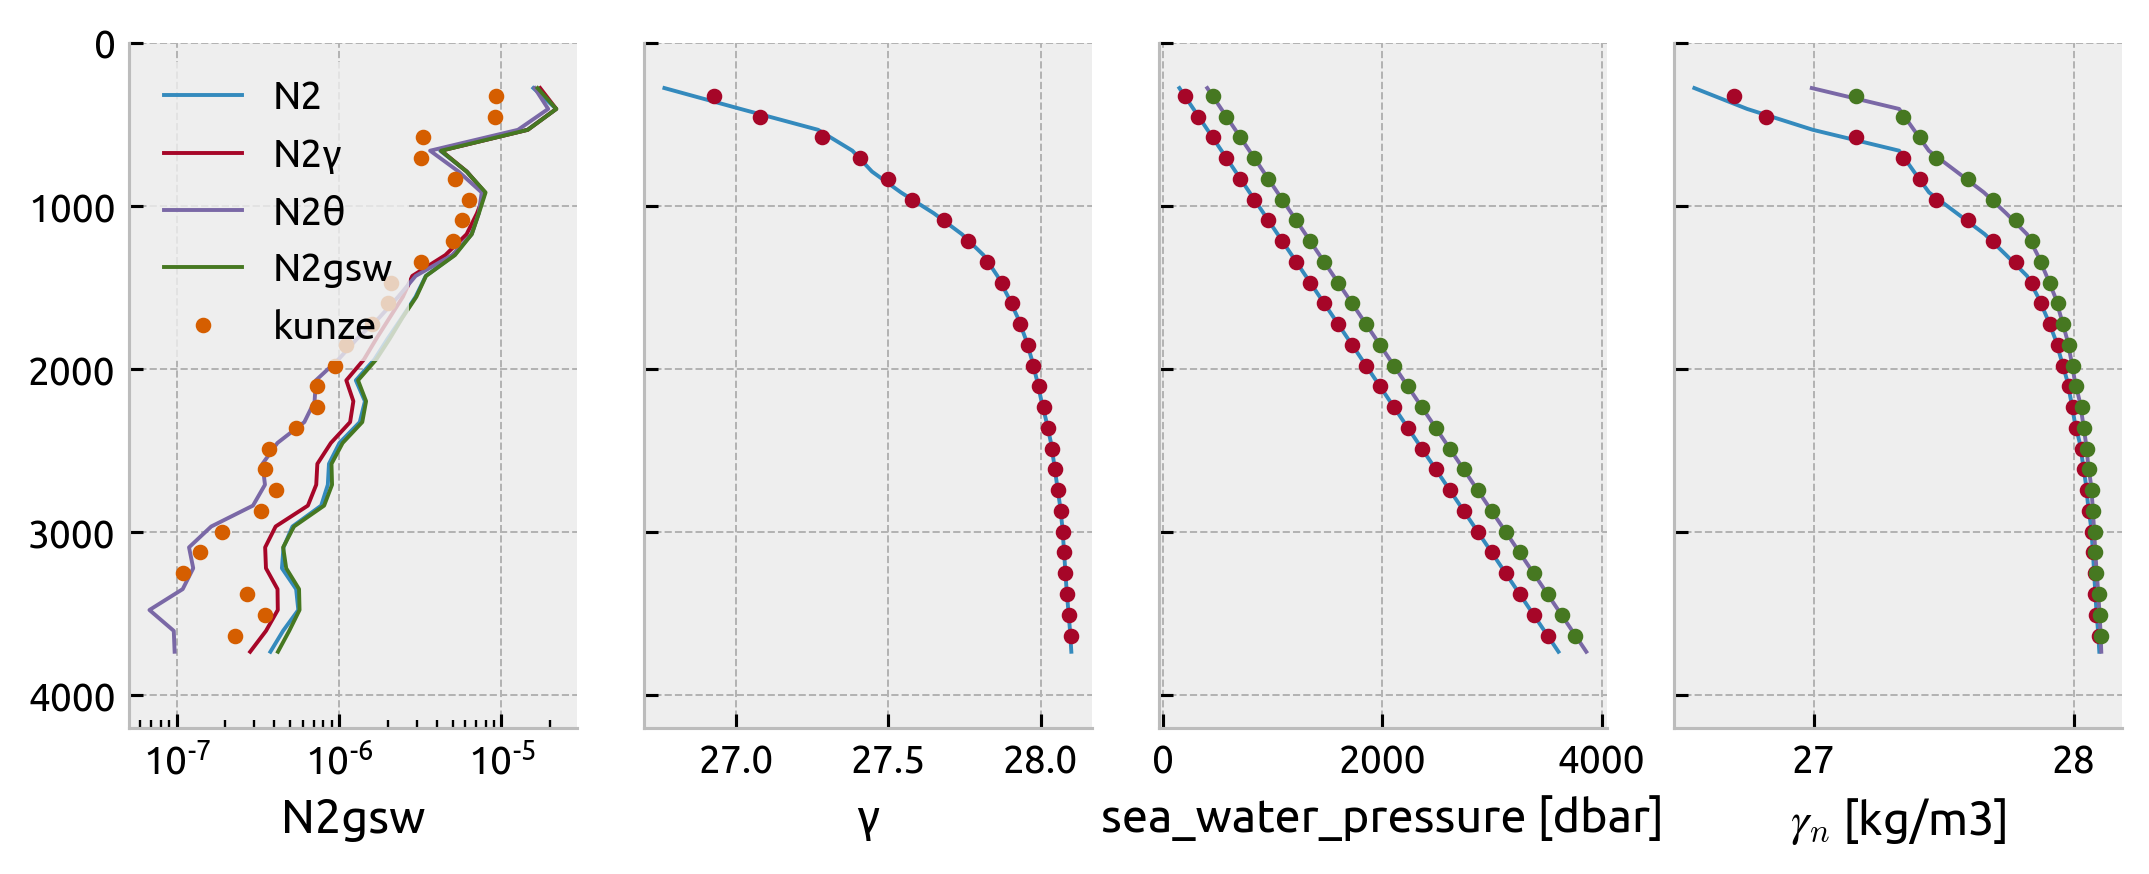

In [15]:
f, ax = plt.subplots(1, 4, sharey=True)

axx = ax.ravel()
for var in ["N2", "N2γ", "N2θ", "N2gsw"]:
    segmented[var].mean("segment").plot(
        y="pres_mean", ax=axx[0], label=var, xscale="log"
    )
# (segmented.N2_γ.mean("segment")).plot(y="pres_mean", ax=axx[0], xscale="log")
axx[0].plot(kunze_cruise.N2, -1 * kunze_cruise.z_mean, ".", label="kunze")
# mod.N2mean.plot(hue="kind", ax=axx[0], y="depth_bin")
axx[0].legend()

segmented.γ.mean("segment").plot(y="pres_mean", ax=axx[1])
axx[1].plot(kunze_cruise.γ_mean, -1 * kunze_cruise.z_mean, ".")

segmented.pres.isel(segment=0).plot(y="pres_mean", ax=axx[2])
axx[2].plot(-1 * kunze_cruise.z_i, -1 * kunze_cruise.z_mean, ".")
segmented.pres.isel(segment=-1).plot(y="pres_mean", ax=axx[2])
axx[2].plot(-1 * kunze_cruise.z_f, -1 * kunze_cruise.z_mean, ".")

segmented.γ.isel(segment=0).plot(y="pres_mean", ax=axx[3])
axx[3].plot(kunze_cruise.γ_i, -1 * kunze_cruise.z_mean, ".")
segmented.γ.isel(segment=-1).plot(y="pres_mean", ax=axx[3])
axx[3].plot(kunze_cruise.γ_f, -1 * kunze_cruise.z_mean, ".")

[aa.set_title("") for aa in axx]
[aa.set_ylabel("") for aa in axx]
plt.tight_layout()
axx[0].set_ylim([4200, 0])
f.set_size_inches((8, 3))

------------ mixsea


/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/deepak/work/python/xarray/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


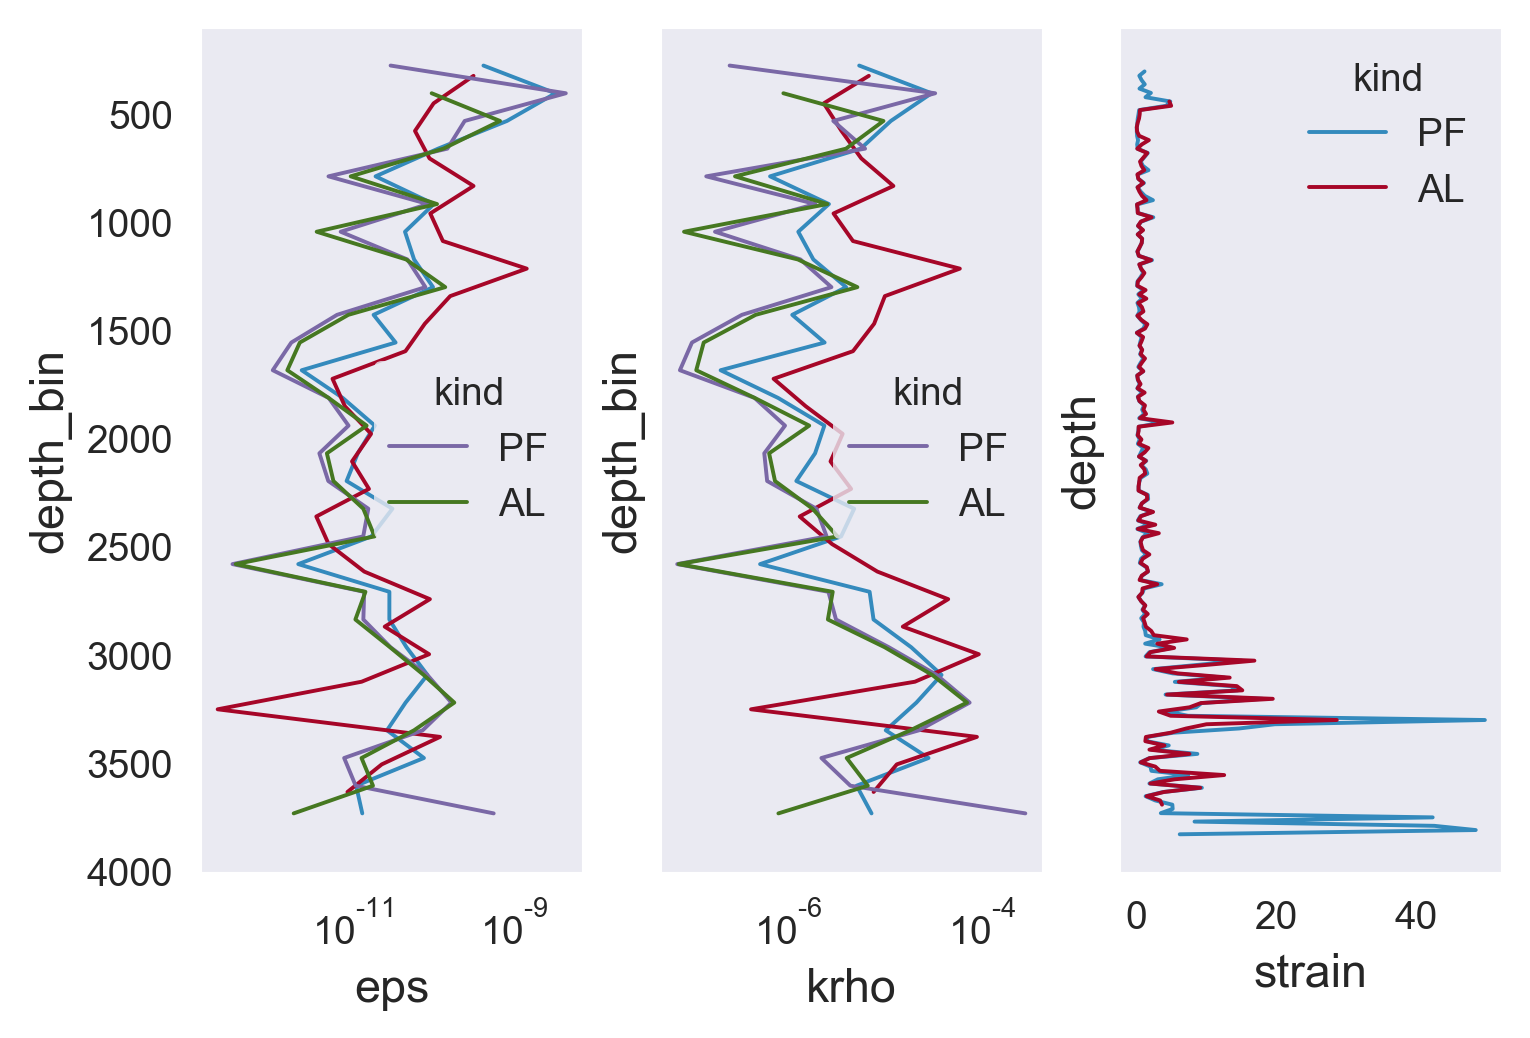

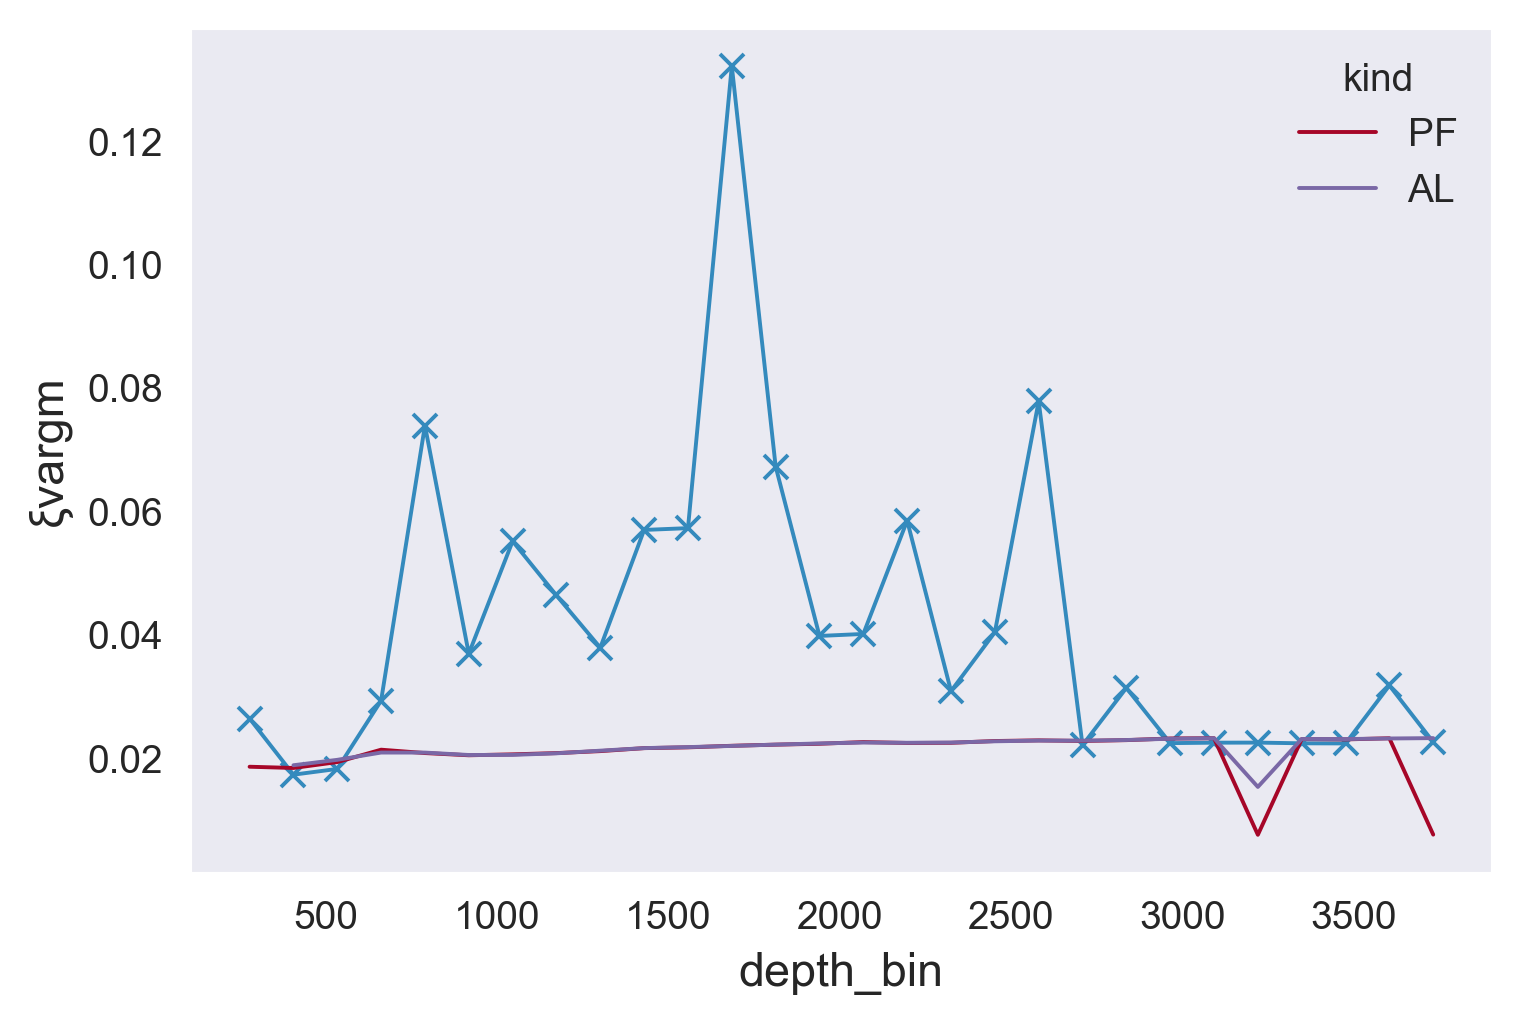

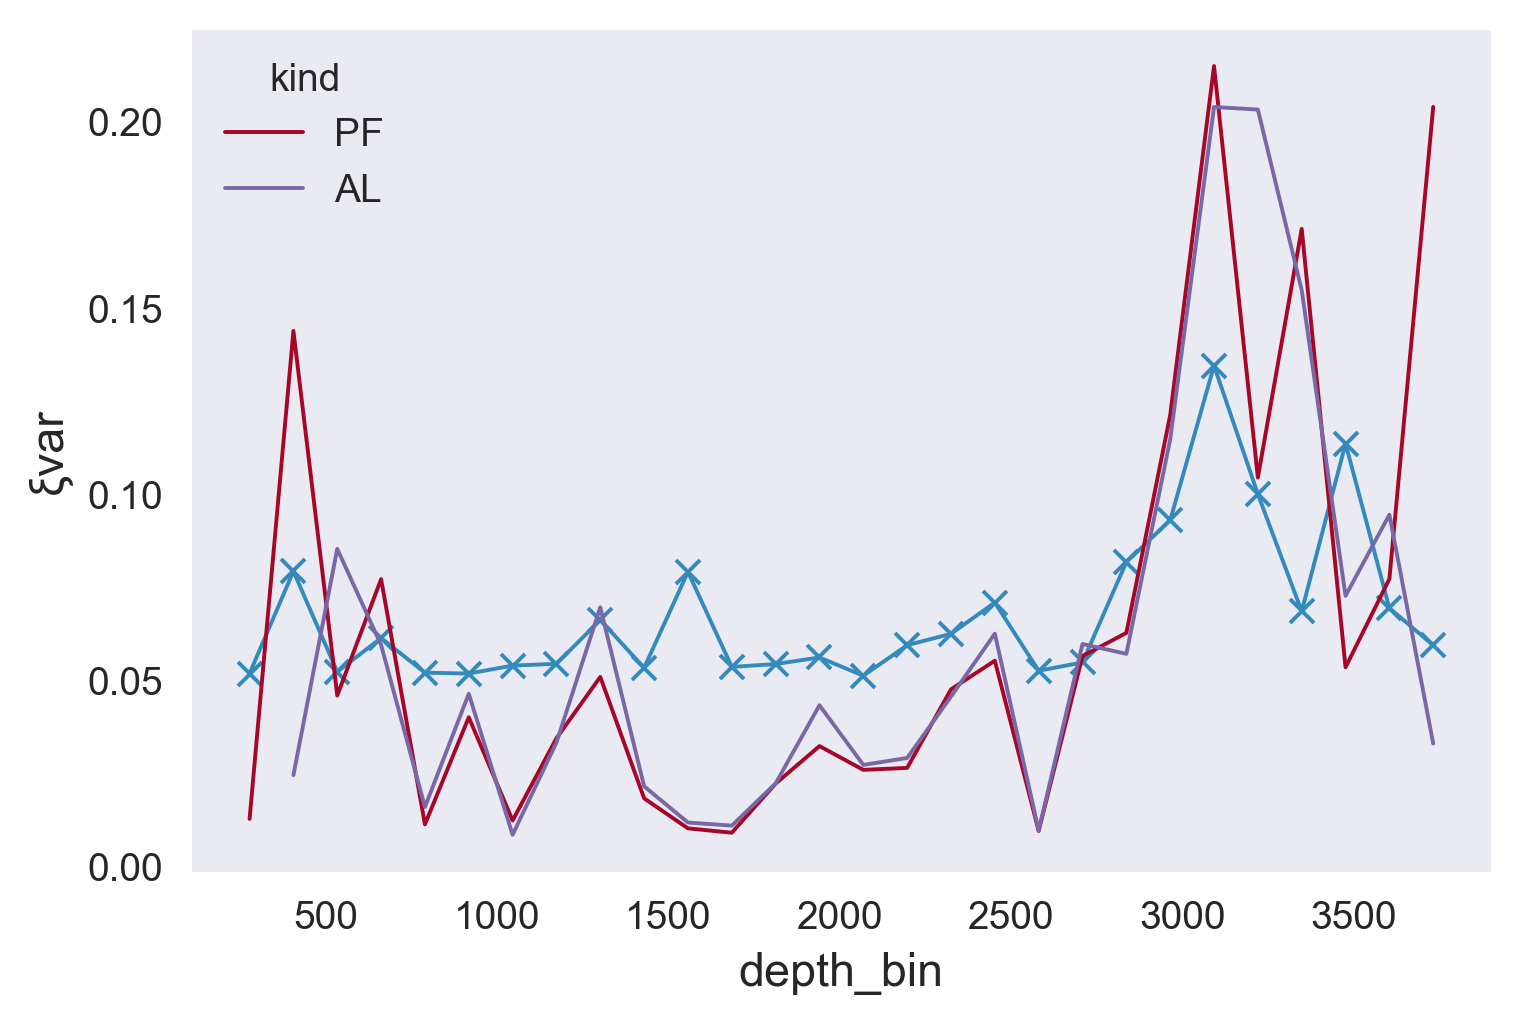

In [23]:
from dcpy.finestructure import do_mixsea_shearstrain, estimate_turb_segment

results = xr.Dataset(coords={"pressure": segmented.pres_mean})
for var in ["K", "ε", "ξvar", "ξvargm"]:
    results[var] = xr.full_like(segmented.pressure, np.nan)

for idx in range(segmented.sizes["pressure"]):
    seg = segmented.isel(pressure=idx, drop=True).set_coords("pres")
    (
        results.K.data[idx],
        results.ε.data[idx],
        results.ξvar.data[idx],
        results.ξvargm.data[idx],
        _,
        _,
    ) = estimate_turb_segment(
        seg.cf["sea_water_pressure"].data + 1,
        seg.N2.data,
        seg.cf["latitude"].item(),
        crit="kunze",
    )

print("------------ mixsea")

mod = do_mixsea_shearstrain(
    profile.isel(pressure=slice(148, None)), segmented.pres_mean.data
)

f, ax = plt.subplots(1, 3, sharey=True)
results.ε.cf.plot(xscale="log", ax=ax[0])
ax[0].plot(kunze_cruise.ε, -1 * kunze_cruise.z_mean)
mod.eps.plot(hue="kind", ax=ax[0], y="depth_bin")

results.K.cf.plot(xscale="log", ax=ax[1])
ax[1].plot(kunze_cruise.K, -1 * kunze_cruise.z_mean)
mod.krho.plot(hue="kind", ax=ax[1], y="depth_bin")

mod.strain.coarsen(depth=10, boundary="trim").var().plot(
    hue="kind", ax=ax[2], y="depth"
)

plt.figure()
(results.ξvargm).plot(marker="x")
(mod.ξvargm).plot(hue="kind")

plt.figure()
(results.ξvar).plot(marker="x")
mod.ξvar.plot(hue="kind")

# estimate_turb_segment(segmented.isel(pressure=5, drop=True).set_coords("pres"), debug=True)#

In [223]:
segmented.ctd_temperature.polyfit("segment", deg=1)

<xarray.Dataset>
Dimensions:               (degree: 2, pressure: 28)
Coordinates:
  * degree                (degree) int64 1 0
  * pressure              (pressure) float64 404.0 532.0 ... 3.732e+03 3.86e+03
Data variables:
    polyfit_coefficients  (degree, pressure) float64 -0.01245 -0.02878 ... 2.438

### Compare to mixsea & Sensitivity studies

The real difference is because they do some funny interpolating of the spectrum that I do not understand: https://github.com/modscripps/mixsea/blob/2c1a27b5b18d8b28f1af17e6d7dbe0f505ef78d8/mixsea/helpers.py#L169-L178

If I comment out that interp step, spectra agree exactly.

Sensitivity

1. The problem is that the cutoff wavenumber chosen depends a lot on spectrum; and then that determines how much of the GM spectrum is integrated. Taken together you get a lot of sensitivity just from that :/
1. Method of choosing the cutoff wavenumber matters too
1. So does Rω or shear-strain ratio.

I think part of the disagreement is also because the mixsea thing isn't using the same bins

0.19514013600229327 0.11266552715618153
0.1987434107341453 0.0940107853774018


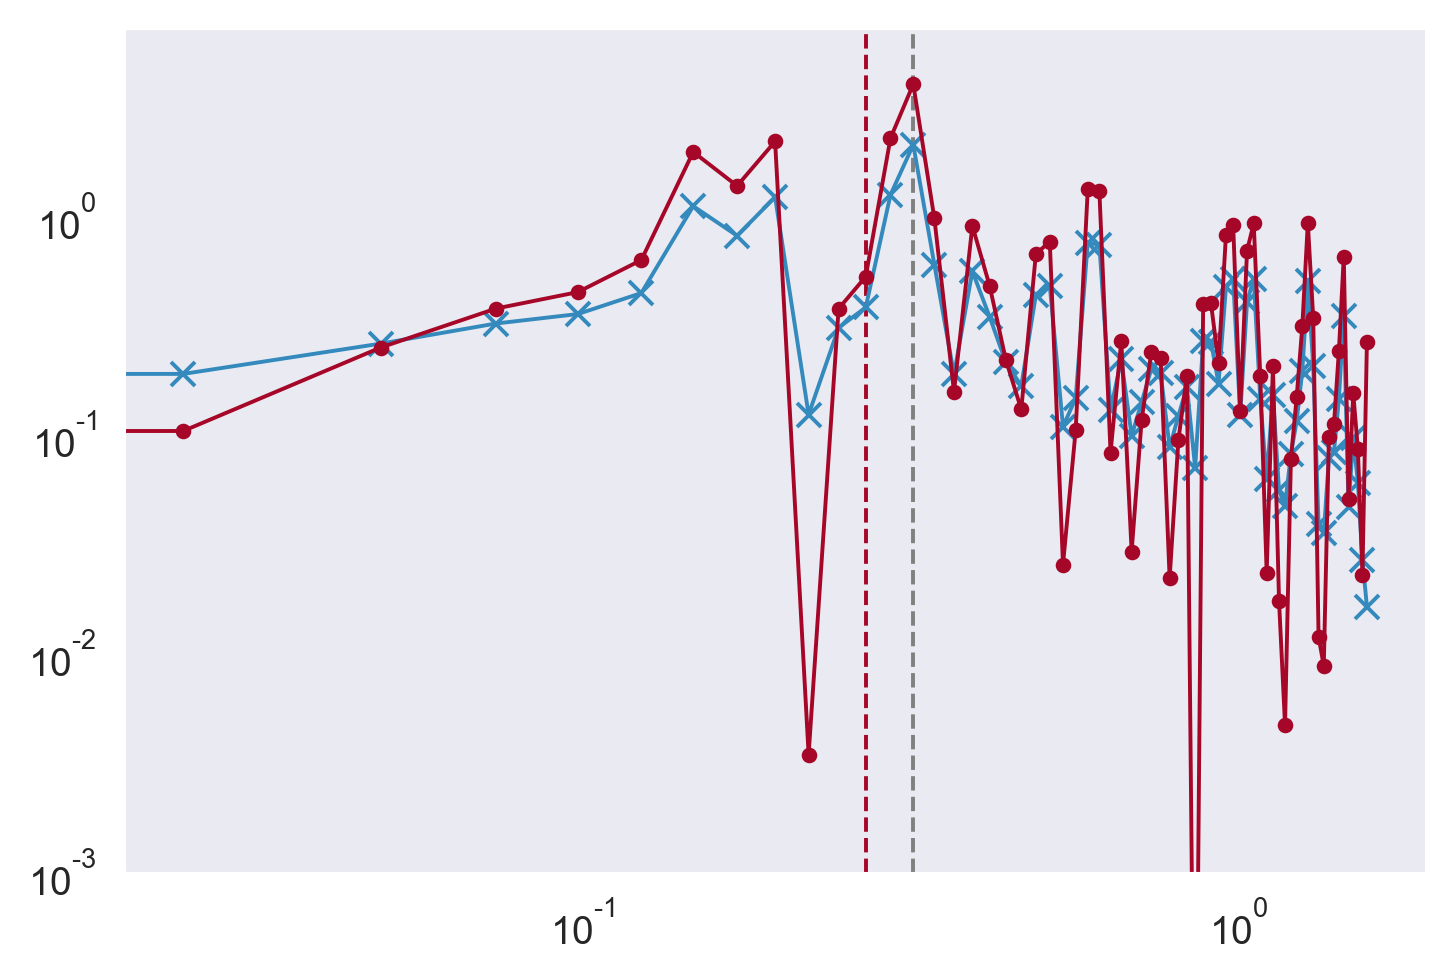

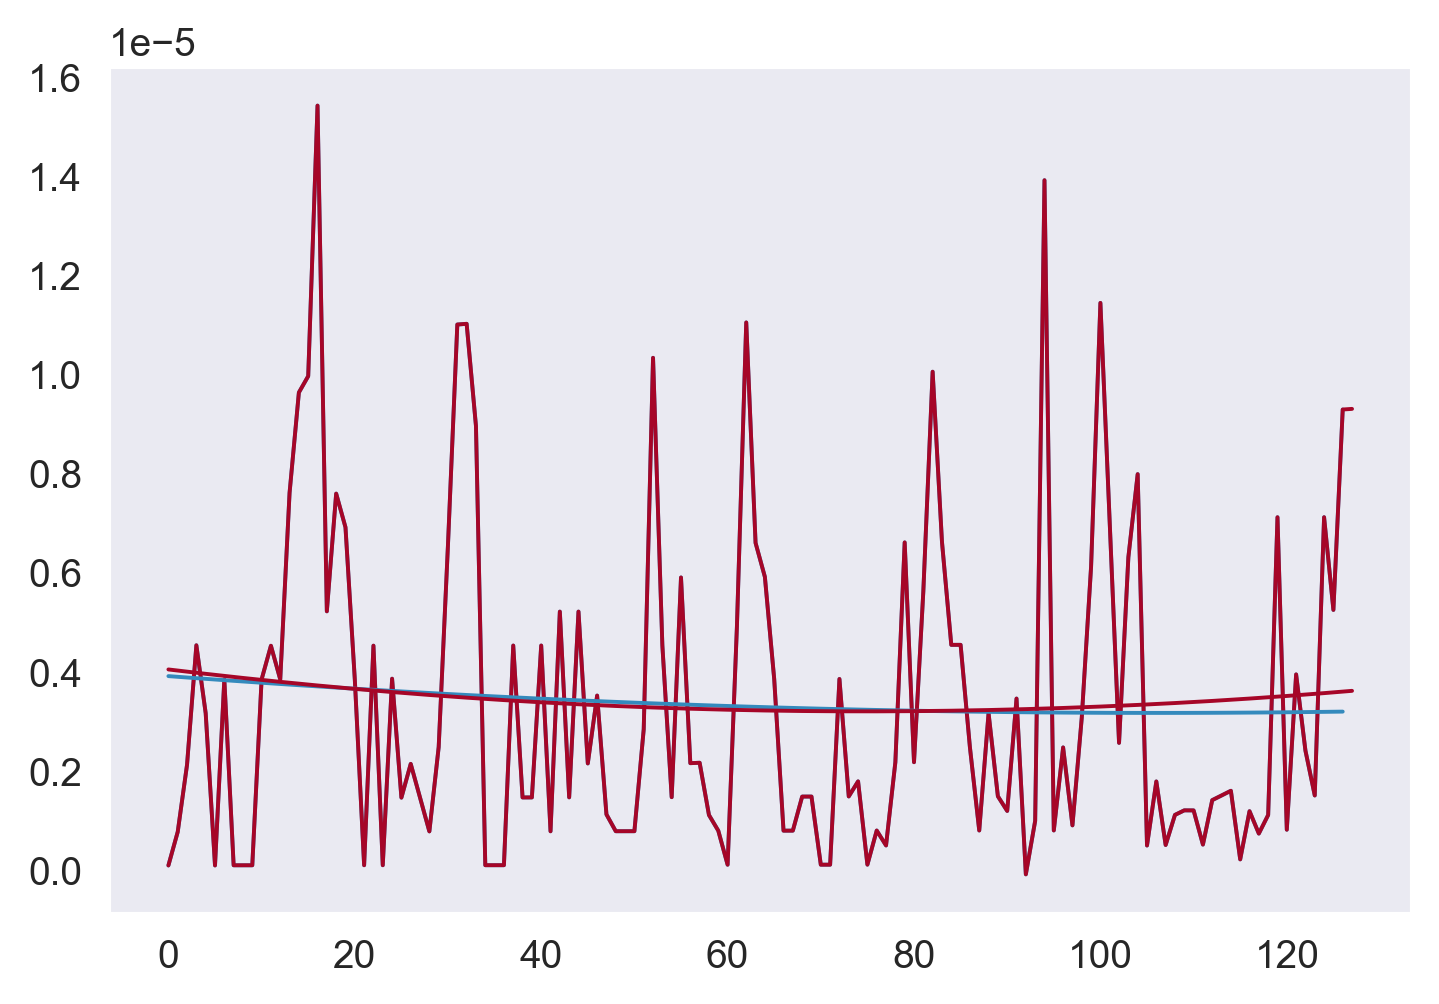

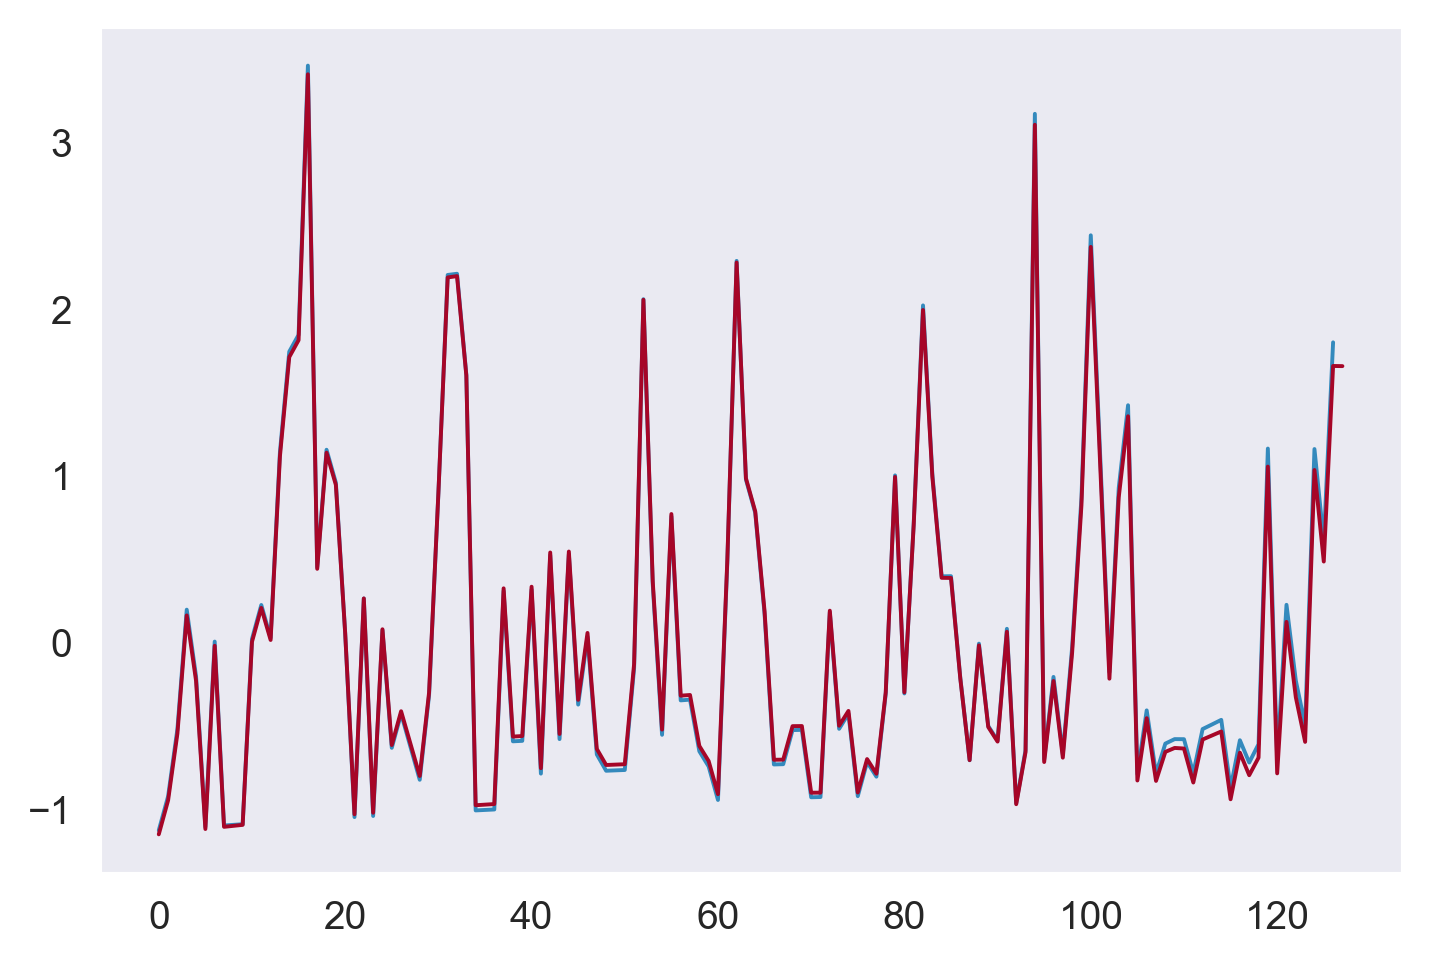

In [24]:
seg = segmented.isel(pressure=9)

dp = 2
N2 = seg.N2gsw
seg["N2fit"] = (
    seg.N2.dims,
    np.polyval(np.polyfit(seg.segment, N2, deg=2), seg.segment),
)
ξ = (N2 - seg.N2fit) / seg.N2fit.mean()
N = np.sqrt(seg.N2fit.mean())

_, _, Ptot, m = mixsea.helpers.psd(ξ.data, dp, ffttype="t", window="hamming")

npts = len(ξ.data)
window = signal.get_window("hann", npts)
window /= np.sqrt(np.sum(window**2) / len(window))
kz, psd = signal.periodogram(
    ξ.data, window="hamming", fs=2 * np.pi / dp, detrend="linear", scaling="density"
)
# psd /= np.sinc(kz * dp / 2 / np.pi) ** 2

strain = mixsea.shearstrain.strain_polynomial_fits(
    -1 * gsw.z_from_p(seg.pres_mean.data - 127 + seg.segment.data, seg.latitude.data),
    seg.ctd_temperature.data,
    seg.ctd_salinity.data,
    seg.longitude.data,
    seg.latitude.data,
    # bin_width=64,
    depth_bin=[seg.pres_mean.data],
    window_size=350,
)


plt.loglog(m, Ptot, "x-")
ax = plt.gca()
imix, _ = mixsea.shearstrain.find_cutoff_wavenumber(Ptot, m, 0.22)
dcpy.plots.linex(m[imix[-1]])
print(
    np.trapz(np.real(Ptot[imix]), m[imix]),
    mixsea.shearstrain.gm_strain_variance(m, imix, np.sqrt(strain[0]["N2mean"]))[0],
)

plt.loglog(kz, psd, ".-")
imix, _ = mixsea.shearstrain.find_cutoff_wavenumber(psd, kz, 0.22)
dcpy.plots.linex(kz[imix[-1]], color="C1")
print(
    np.trapz(psd[imix], kz[imix]),
    mixsea.shearstrain.gm_strain_variance(kz, imix, N.data)[0],
)
plt.ylim([1e-3, None])


plt.figure()
plt.plot(strain[0]["N2"])
plt.plot(N2)
plt.plot(strain[0]["N2smooth"], color="C0")
plt.plot(seg.N2fit, color="C1")

plt.figure()
plt.plot(strain[0]["strain"])
plt.plot(ξ)

GM spectrum is right

0.22007432494266535
0.22007432494266535


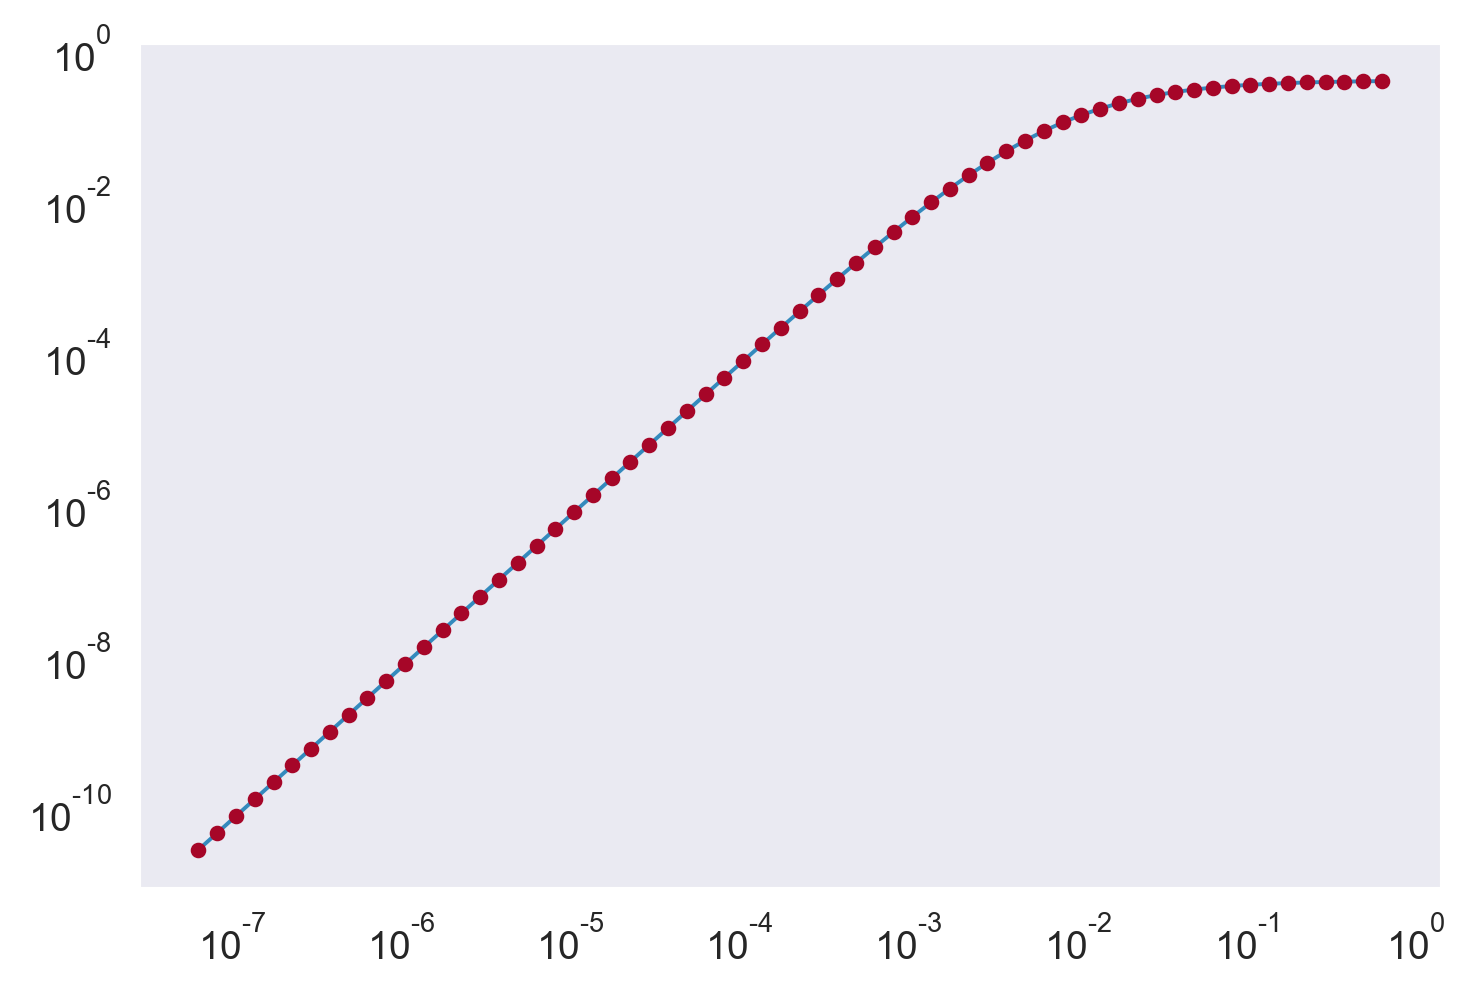

In [25]:
# GM 75; Kunze et al (2017)
E0 = 6.3e-5  # nondim spectral energy level
jstar = 3  # peak mode numebr
b = 1300  # m; stratification length scale
N0 = 5.24e-3  # rad/s
K_0 = 5e-6  # m²/s for a mixing efficiency of Γ=0.2
N = N0

kz = 2 * np.pi * np.logspace(-8, -1, 64)  # np.fft.fftfreq(n=1024, d=0.1)[:64]
kzstar = (np.pi * jstar / b) * (N / N0)
ξgm = np.pi * E0 * b / 2 * jstar * kz**2 / (kz + kzstar) ** 2
plt.loglog(kz, ξgm)
print(np.trapz(ξgm, kz))

Sgm, Pgm = mixsea.shearstrain.gm_strain_variance(kz, np.arange(len(kz)), 5.24e-3)
print(Sgm)
plt.plot(kz, Pgm, ".")

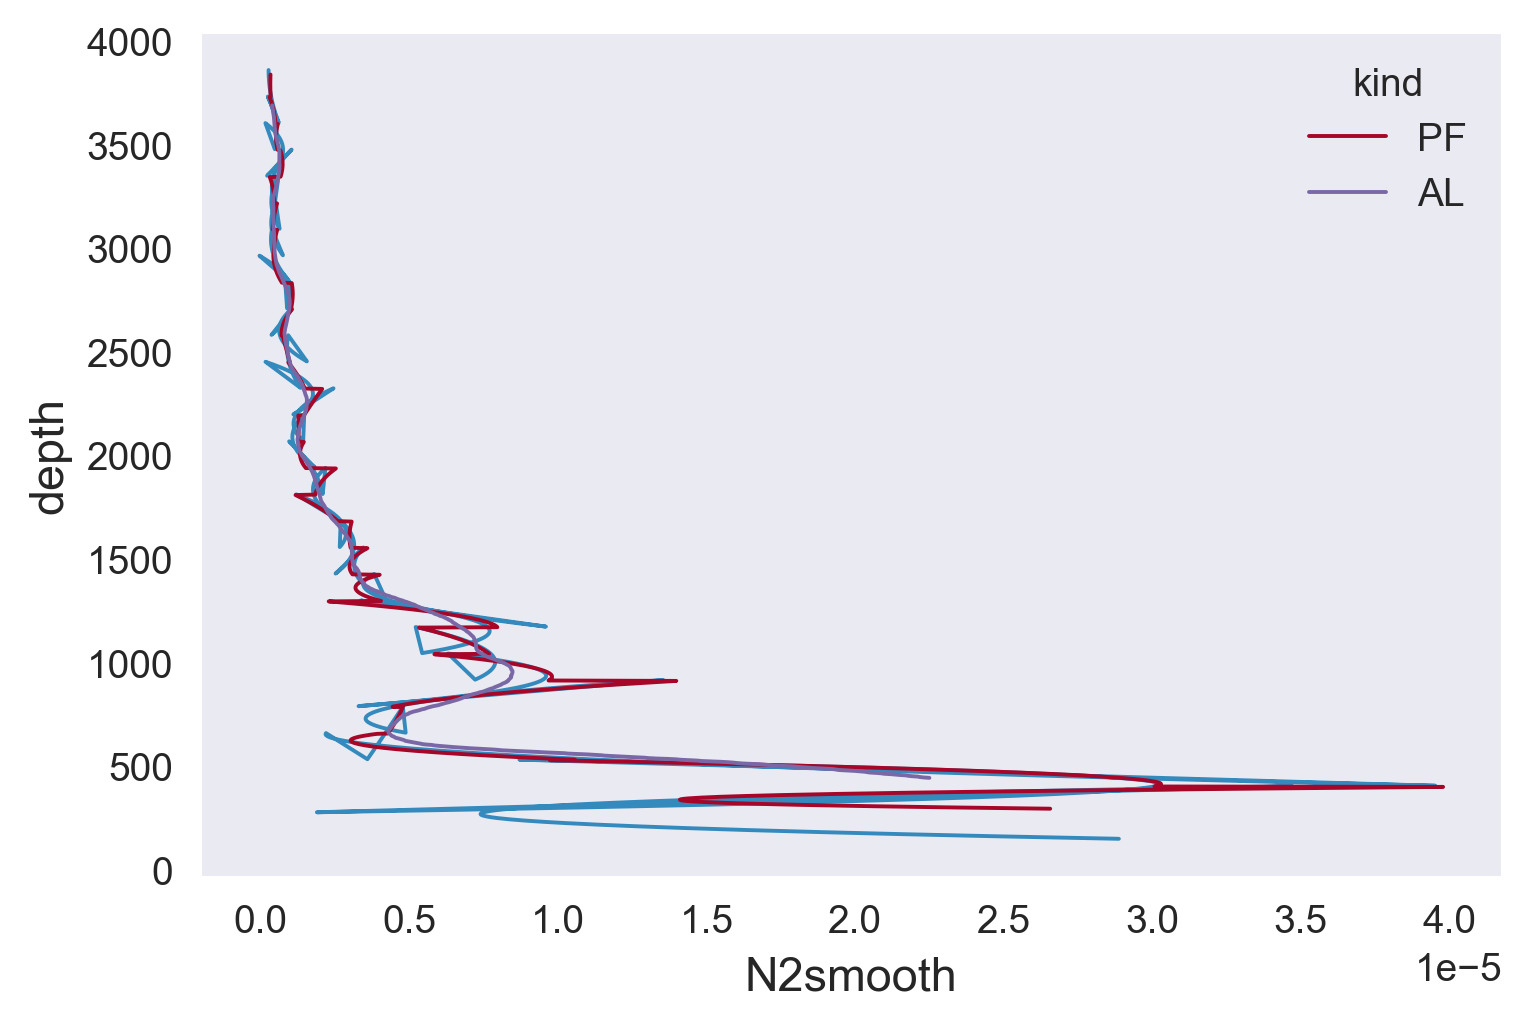

In [26]:
coeffs = segmented.N2.polyfit(deg=2, dim="segment")
smoothed = xr.polyval(segmented.segment, coeffs).rename(
    {"polyfit_coefficients": "N2smooth"}
)
stacked = (
    smoothed.transpose(..., "segment")
    .assign_coords(pres=segmented.pres)
    .stack({"p": ("pressure", "segment")})
)
p0, p1 = stacked.pressure.data[0], stacked.pressure.data[-1]
N2smth = (
    stacked.drop("p").rename({"pres": "pressure"}).swap_dims({"p": "pressure"}).N2smooth
)
N2smth.plot(y="pressure")
mod.N2smooth.plot(y="depth", hue="kind")